In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = [redacted] host = 127.0.0.1 port=5432')

#Query the database to recover the needed data for unsupervised learning operations

#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT * FROM features_rev_prop'''

ml_df_full = pd.read_sql(ds_query, connct)

ml_df_full.head()

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  maillard_prop  \
0           0    0.400000   0.200000    0.400000    0.000000       0.000000   
1           1    0.400000   0.000000    0.000000    0.200000       0.400000   
2           2    0.166667   0.333333    0.166667    0.166667       0.166667   
3           3    0.250000   0.000000    0.000000    0.750000       0.000000   
4           4    0.333333   0.000000    0.000000    0.500000       0.166667   

   smoke_prop  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [2]:
#connct.close()

I am choosing DBSCAN for clustering analysis because there are a lot of points that look like noise points, and a lot of the points look like noise points. Kmeans and agglomerative clustering are bad for irregular shaped clusters. 

In [3]:
#git rid of whiskey_id

ml_df = ml_df_full.drop(['whiskey_id'], axis = 1)

#check for missing values
ml_df.isnull().sum()

fruit_prop       0
wood_prop        0
spicy_prop       0
sweet_prop       0
maillard_prop    0
smoke_prop       0
dtype: int64

In [4]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_prop     5900 non-null   float64
 1   wood_prop      5900 non-null   float64
 2   spicy_prop     5900 non-null   float64
 3   sweet_prop     5900 non-null   float64
 4   maillard_prop  5900 non-null   float64
 5   smoke_prop     5900 non-null   float64
dtypes: float64(6)
memory usage: 276.7 KB


I am going to try implementing the DBSCAN clustering alogrythm using scikit learn. I have questions about how well it will work. If it doesn't work, I don't think other clustering algorythms are necessarily likely to work better because of the irregular appearance of some of the clusters when I run t-SNE. An idea I have for refactoring the project is to combine features that seem related - for instance sugar, sweet and honey could all go in the same features, and some of the fruit descriptors could be summed in another feature. This reduceds the dimensionality of the feature space along defensible lines, and may make it easier to spot clusters and patterns.  

In [5]:
#import some necessary things from sklearn

import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


In [6]:
#rename the df because no scaling is needed this time

ml_scale = ml_df

In [7]:
#I used min max scaler, which should put all the features between 0 and 1. this means my epsilon (neighborhood) value for 
#DBSCAN needs to be small. I'm going to start with 0.05
#min samples should be kind of large because there are 5900 points in the set. 25 seems like a reasonable value to start. 

cls_1 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

cls_1

array([-1, -1,  0, ..., -1, -1, -1], dtype=int64)

In [8]:
# my preferred t-SNE parameters were tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)
#copying over my helpful t-SNE functions for visualizing my clustering

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()


In [9]:
#constructing a dataframe for t-SNE visualization of clustering
pref_tsne = TSNE(random_state=42, perplexity = 30, learning_rate = 1000)

db_tsne1 = pref_tsne.fit_transform(ml_scale)

pref_tsne_x = []
pref_tsne_y = []

tsne_unpack(db_tsne1, pref_tsne_x, pref_tsne_y)

vis1_dict = {'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis_1 = pd.DataFrame(vis1_dict)

vis_1.head()

tSNE_x     tSNE_y
0  45.758720 -15.304592
1 -36.757694  25.302685
2   2.562958  16.394543
3  15.950294  81.161903
4 -37.445004  33.395908

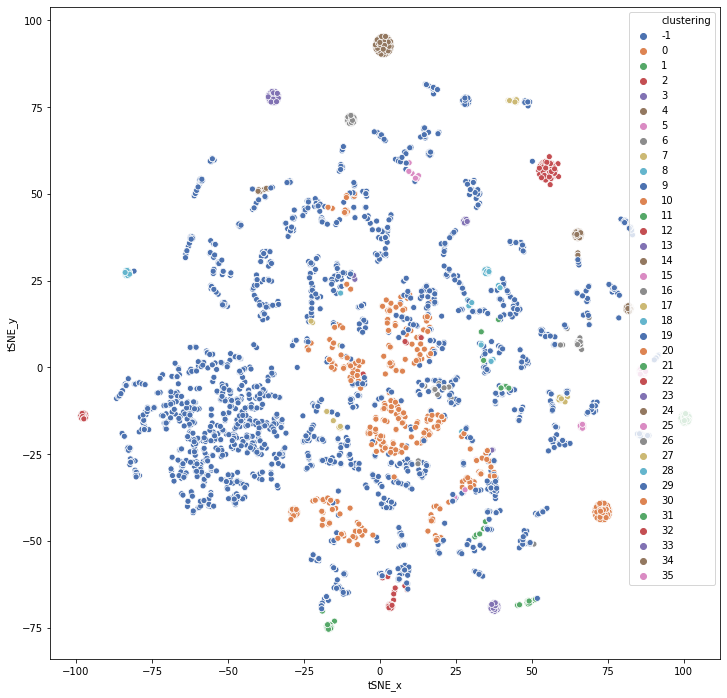

In [10]:
# adding clustering data as a new column, and visualizing

vis_1['clustering'] = cls_1

plt.figure(figsize = (12, 12))
sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

plt.show()

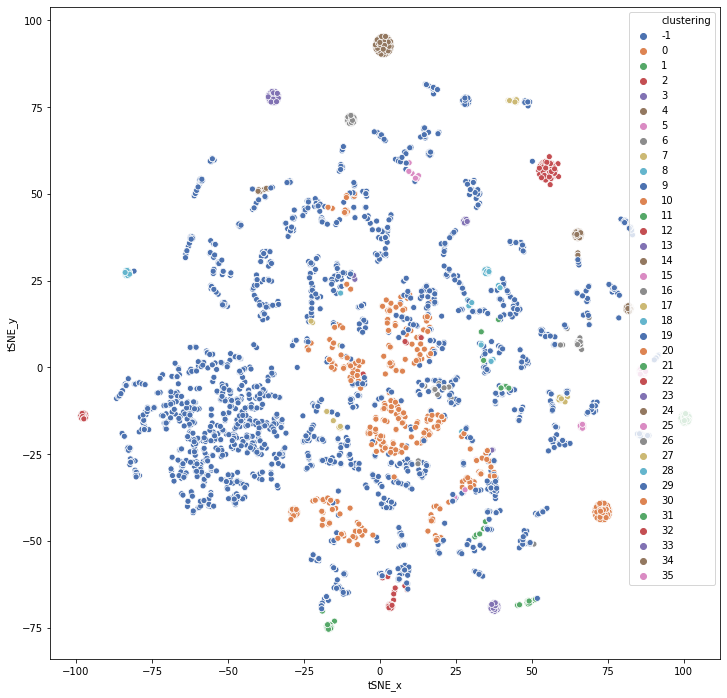

In [11]:
#elbow function is different, but still not sure I've got it right. I'm going to try a few new values for clustering (again) though, 
#based on the scales I'm seeing. 

cls_2 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

#write a function to make visualizing clustering results on the t-SNE picture really easy

def cluster_vis(dbscan_array):
    vis_1['clustering'] = dbscan_array

    plt.figure(figsize = (12, 12))
    sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()

cluster_vis(cls_2)
    

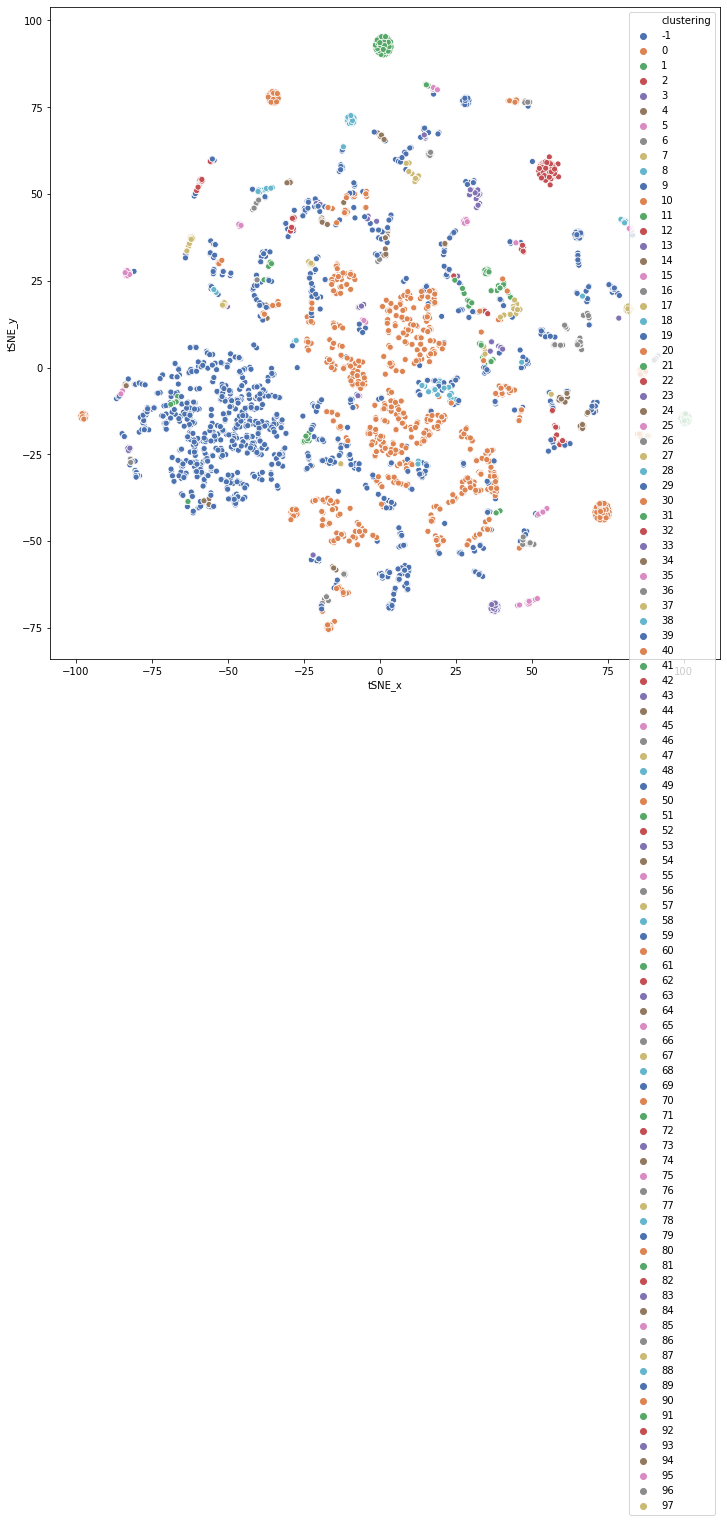

In [12]:
cls_3  = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(ml_scale) 

cluster_vis(cls_3)

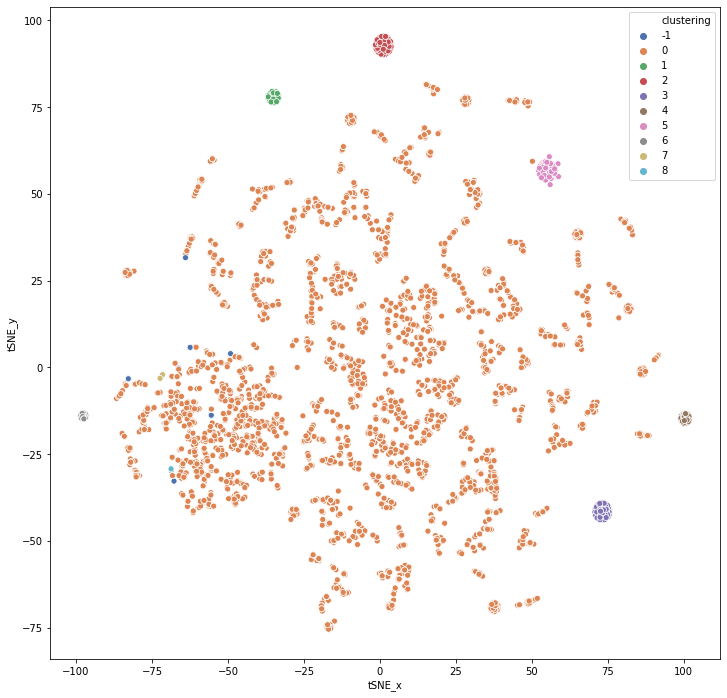

In [13]:
cls_4 = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_4)

From too many to not enough.

In [14]:
#set up silhouette score
from sklearn.metrics import silhouette_score

print(f'silhouette score w noise{silhouette_score(ml_scale, cls_4)}')



silhouette score w noise0.06300538789881123


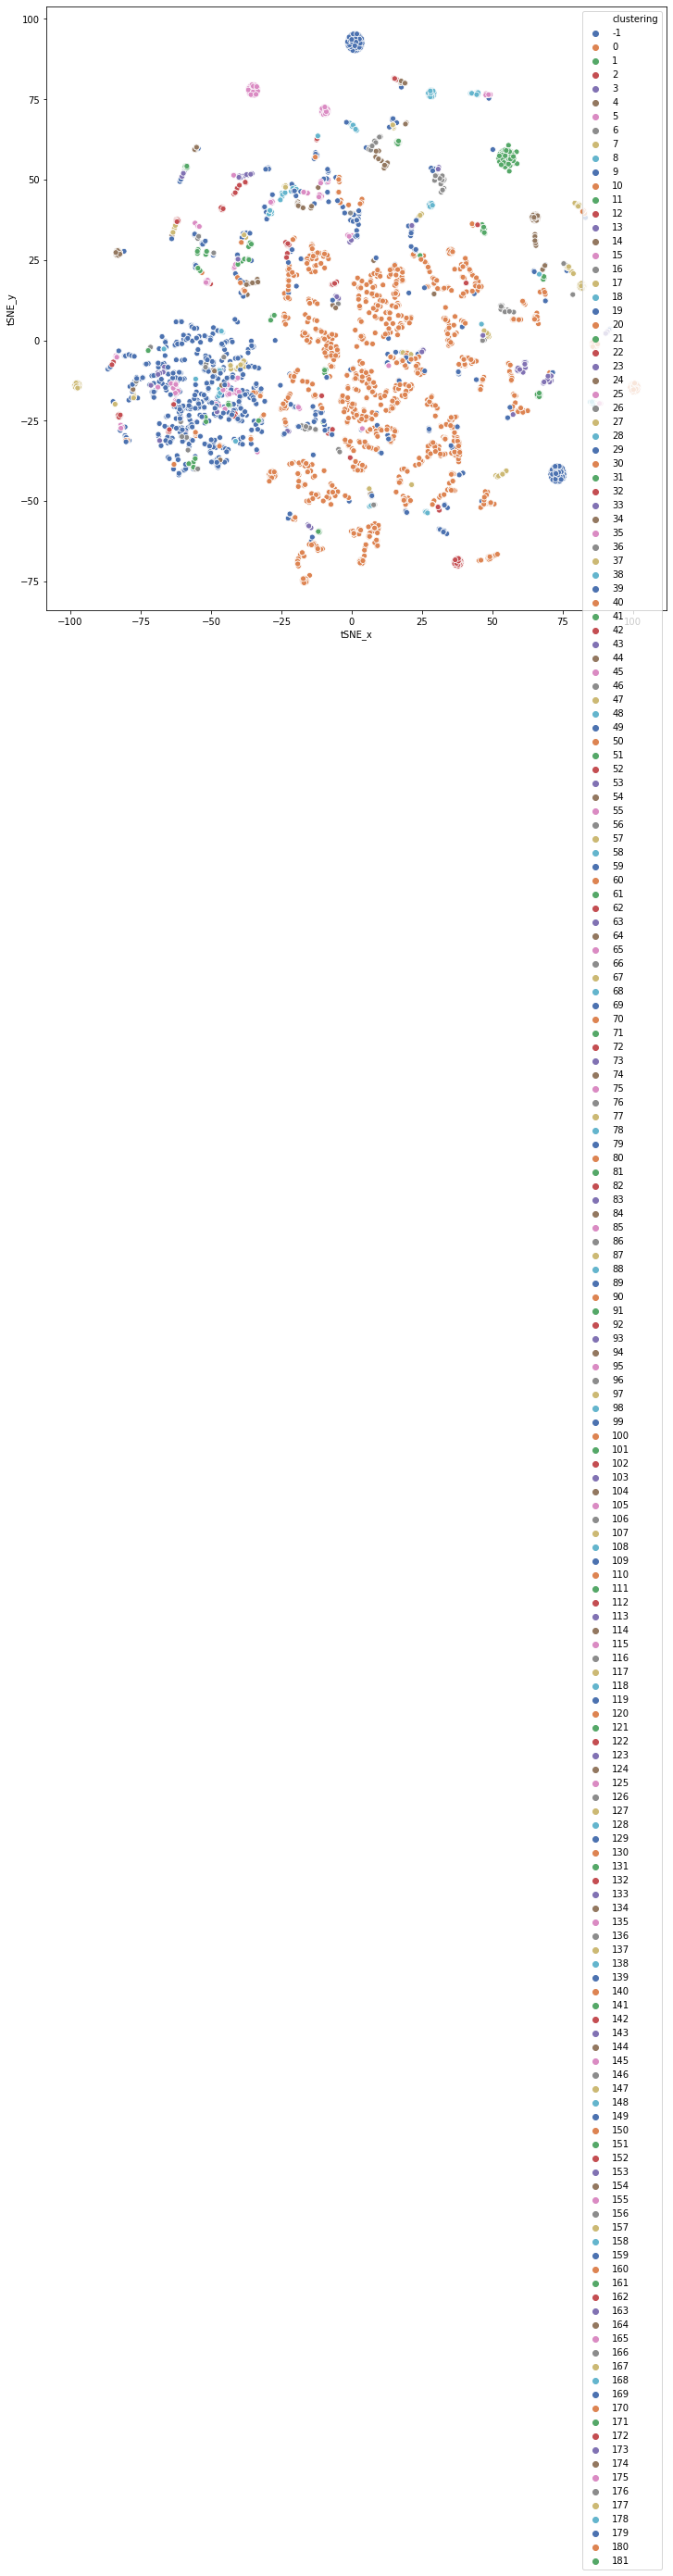

In [15]:
cls_5 = DBSCAN(eps = 0.1, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_5)

In [16]:
print(f'silhouette score w noise{silhouette_score(ml_scale, cls_5)}')

silhouette score w noise0.04597059168104936


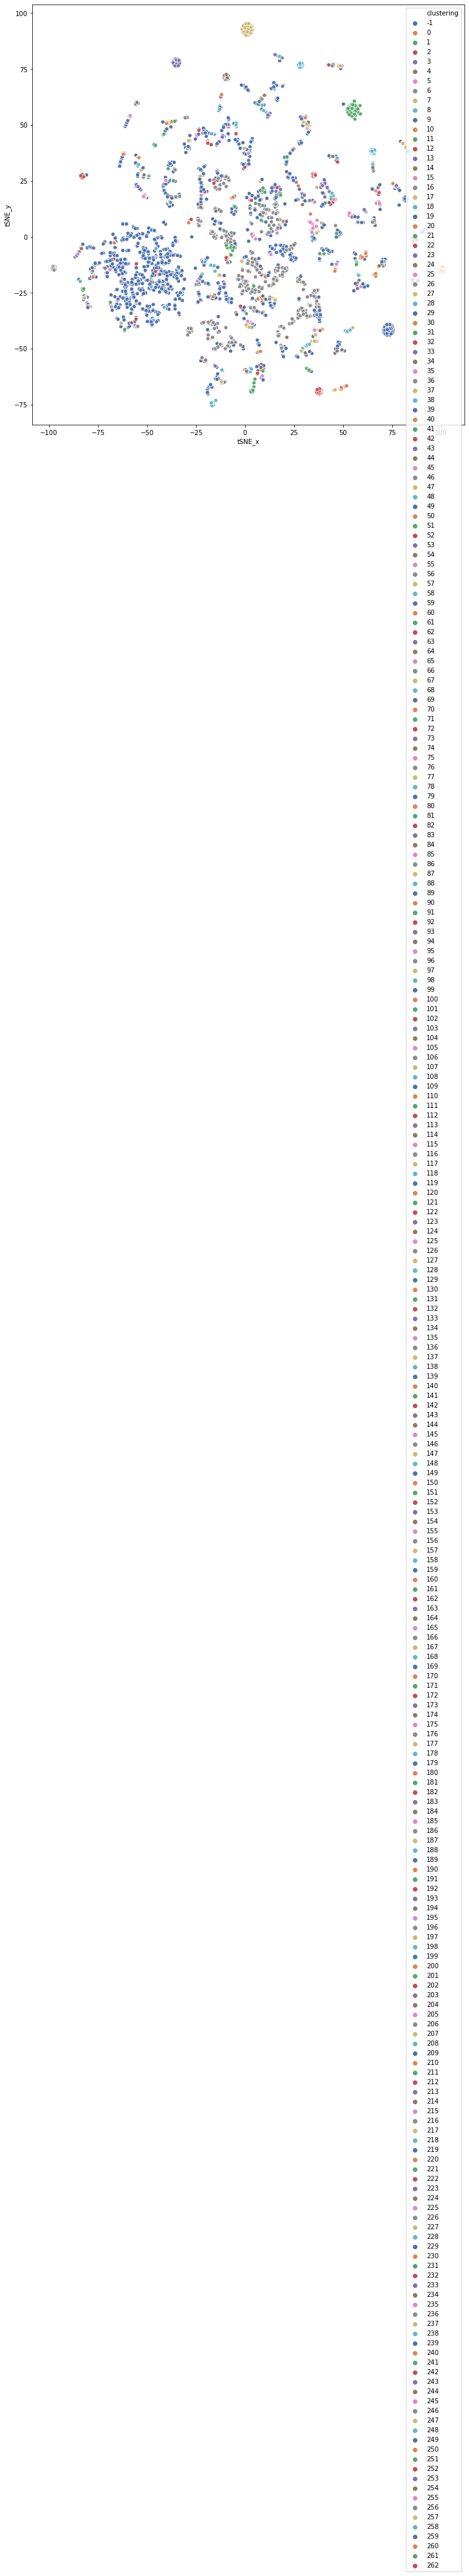

In [17]:
cls_6 = DBSCAN(eps = 0.08, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_6)

In [18]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_6)}')

silhouette score w noise 0.2110339142986176


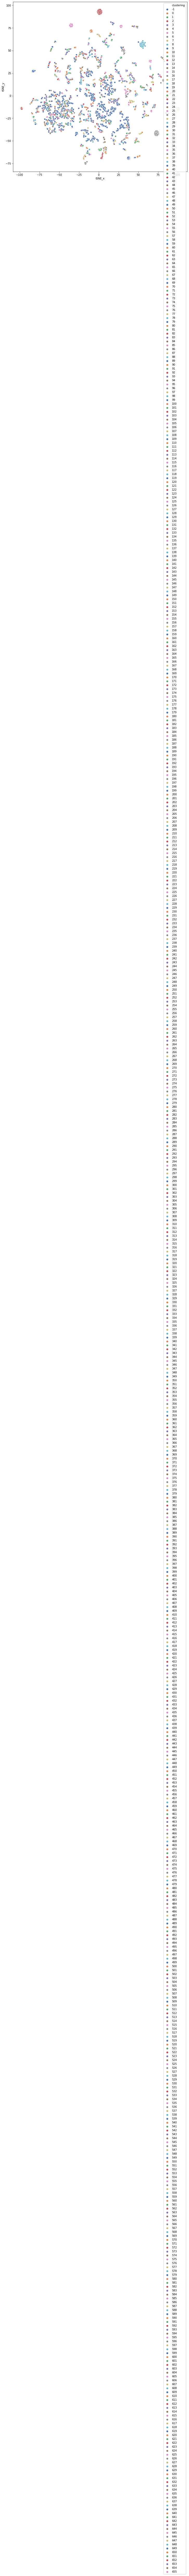

In [19]:
cls_7 = DBSCAN(eps = 0.08, min_samples = 2).fit_predict(ml_scale)

cluster_vis(cls_7)

In [20]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.4358040007449252


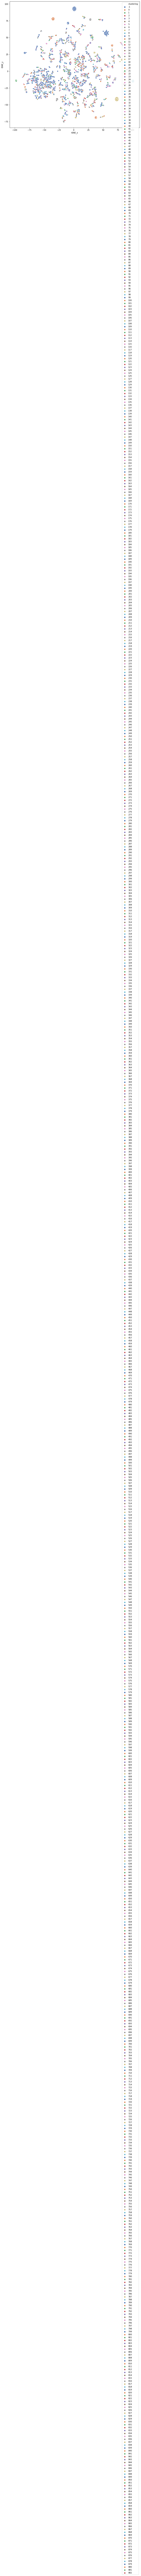

In [21]:
cls_8 = DBSCAN(eps = 0.06, min_samples = 2).fit_predict(ml_scale)

cluster_vis(cls_8)

In [23]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_8)}')

silhouette score w noise 0.6618717324597707


# Look at a Few Methods Run with these features

The goal is to see if this version of the features can outperform the last one for proportion of the whiskeys clustered.

In [24]:
ml_df_cl8 = ml_df_full

ml_df_cl8['clustering'] = cls_8

cl8_count = ml_df_cl8.groupby('clustering').count()

cl8_count

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  \
clustering                                                              
-1                 956         956        956         956         956   
 0                  13          13         13          13          13   
 1                   5           5          5           5           5   
 2                  19          19         19          19          19   
 3                   7           7          7           7           7   
...                ...         ...        ...         ...         ...   
 878                 2           2          2           2           2   
 879                 2           2          2           2           2   
 880                 2           2          2           2           2   
 881                 2           2          2           2           2   
 882                 2           2          2           2           2   

            maillard_prop  smoke_prop  
clustering                             
-1                    956         956  
 0                     13          13  
 1                      5           5  
 2                     19          19  
 3                      7           7  
...                   ...         ...  
 878                    2           2  
 879                    2           2  
 880                    2           2  
 881                    2           2  
 882                    2           2  

[884 rows x 7 columns]

In [31]:
#try with clustering method 7
ml_df_cl7 = ml_df_full

ml_df_cl7['clustering'] = cls_7

cl7_count = ml_df_cl7.groupby('clustering').count()

cl7_count = cl7_count[['whiskey_id']].copy()

cl7_count

whiskey_id
clustering            
-1                 525
 0                  15
 1                   6
 2                  19
 3                  12
...                ...
 651                 2
 652                 2
 653                 2
 654                 2
 655                 2

[657 rows x 1 columns]

In [32]:
#get some stats on cluster sizes for this method

cl7_count.describe()

whiskey_id
count  657.000000
mean     8.980213
std     42.144799
min      2.000000
25%      2.000000
50%      3.000000
75%      7.000000
max    924.000000

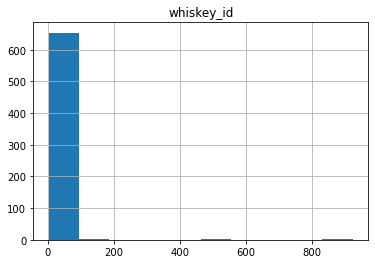

In [33]:
cl7_count.hist()

plt.show()

In [35]:
cl7_count = cl7_count.sort_values(by = 'whiskey_id', ascending = False)

cl7_count.head()

whiskey_id
clustering            
 9                 924
-1                 525
 68                 96
 42                 90
 66                 84

In [37]:
#investigate cluster 9

cluster9 = ml_df_cl7[ml_df_cl7['clustering'] == 9]

cluster9.head(20)

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  maillard_prop  \
10           10    0.500000   0.100000    0.100000    0.000000       0.300000   
11           11    0.166667   0.166667    0.333333    0.166667       0.166667   
12           12    0.272727   0.181818    0.454545    0.000000       0.090909   
15           15    0.333333   0.333333    0.166667    0.000000       0.166667   
24           24    0.285714   0.142857    0.142857    0.000000       0.428571   
25           25    0.222222   0.111111    0.111111    0.111111       0.444444   
29           29    0.272727   0.090909    0.363636    0.090909       0.181818   
33           33    0.333333   0.333333    0.166667    0.000000       0.166667   
35           35    0.461538   0.076923    0.384615    0.000000       0.076923   
36           36    0.333333   0.166667    0.166667    0.166667       0.166667   
39           39    0.363636   0.272727    0.272727    0.000000       0.090909   
42           42    0.222222   0.333333    0.222222    0.111111       0.111111   
43           43    0.333333   0.222222    0.111111    0.000000       0.333333   
58           58    0.200000   0.400000    0.200000    0.000000       0.200000   
70           70    0.400000   0.200000    0.200000    0.000000       0.200000   
75           75    0.200000   0.200000    0.400000    0.000000       0.200000   
97           97    0.166667   0.333333    0.333333    0.000000       0.166667   
134         134    0.250000   0.083333    0.416667    0.000000       0.250000   
136         136    0.125000   0.125000    0.250000    0.125000       0.375000   
138         138    0.416667   0.166667    0.250000    0.000000       0.166667   

     smoke_prop  clustering  
10          0.0           9  
11          0.0           9  
12          0.0           9  
15          0.0           9  
24          0.0           9  
25          0.0           9  
29          0.0           9  
33          0.0           9  
35          0.0           9  
36          0.0           9  
39          0.0           9  
42          0.0           9  
43          0.0           9  
58          0.0           9  
70          0.0           9  
75          0.0           9  
97          0.0           9  
134         0.0           9  
136         0.0           9  
138         0.0           9

In [38]:
cluster9.describe()

whiskey_id  fruit_prop   wood_prop  spicy_prop  sweet_prop  \
count   924.000000  924.000000  924.000000  924.000000  924.000000   
mean   2547.209957    0.234028    0.213748    0.251461    0.074780   
std    1598.896215    0.099842    0.094280    0.102184    0.082779   
min      10.000000    0.000000    0.066667    0.066667    0.000000   
25%    1132.750000    0.153846    0.142857    0.166667    0.000000   
50%    2625.500000    0.222222    0.200000    0.250000    0.076923   
75%    3765.250000    0.300000    0.272727    0.333333    0.125000   
max    5892.000000    0.600000    0.500000    0.555556    0.400000   

       maillard_prop  smoke_prop  clustering  
count     924.000000       924.0       924.0  
mean        0.225984         0.0         9.0  
std         0.096405         0.0         0.0  
min         0.000000         0.0         9.0  
25%         0.142857         0.0         9.0  
50%         0.200000         0.0         9.0  
75%         0.300000         0.0         9.0  
max         0.500000         0.0         9.0

In [44]:
#visualize cluster 7 on the tsne
#remake vis_1 for visualizing specific clusters

vis2_dict = {'whiskey_id': ml_df_full['whiskey_id'], 'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis2 = pd.DataFrame(vis2_dict)

vis2.head()

whiskey_id     tSNE_x     tSNE_y
0           0  45.758720 -15.304592
1           1 -36.757694  25.302685
2           2   2.562958  16.394543
3           3  15.950294  81.161903
4           4 -37.445004  33.395908

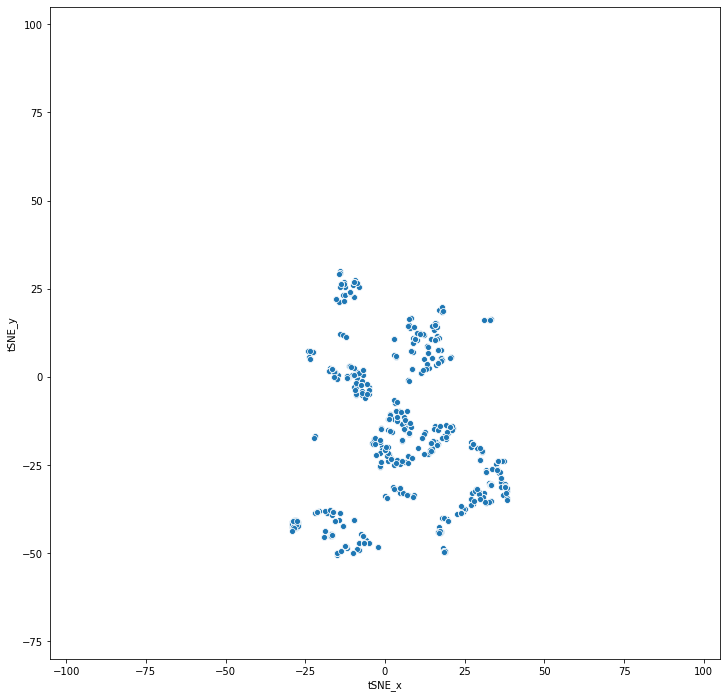

In [56]:
#inner join cluster 9 to vis2 and visualize with a scatter plot

cl9_vis = pd.merge(vis2, cluster9, on = 'whiskey_id')


plt.figure(figsize = (12, 12))
plt.xlim(-105, 105)
plt.ylim(-80, 105)
sns.scatterplot(data = cl9_vis, x = 'tSNE_x', y = 'tSNE_y')

plt.show()

This isnt noise according to the dbscan, but the tsne doesn't show any kind of order with this grouping, and it's hard to see any order in the data itself looking at the set. I can't really conclude that this is a coherent grouping based on what I can see here.

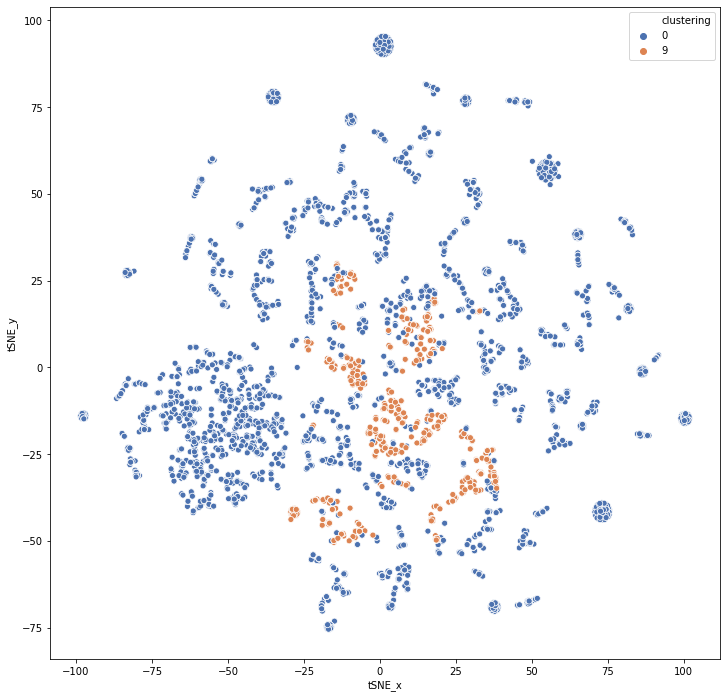

In [67]:
#try a variation where only the cluster is colored, by setting other cluster values than the one targeted to 0
#this can work the same as cluster_vis() but the cluster vector needs to be processed first to make all clusters 0 
# save for the indicated cluster

def vis_ind_clust(dbscan_array, target_cluster, tsne_df):
    
    filt_array = []
    
    for cls in dbscan_array:
        if cls == target_cluster:
            filt_array.append(target_cluster)
        else:
            filt_array.append(0)
    
    vis_1['clustering'] = filt_array
    
    plt.figure(figsize = (12, 12))
    
    #in this sheet vis1 should work as tsne_df
    sns.scatterplot(data = tsne_df, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()


vis_ind_clust(cls_7, 9, vis_1)

In [51]:
cluster2 = ml_df_cl7[ml_df_cl7['clustering'] == 2]

cluster2

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  \
2              2    0.166667   0.333333    0.166667    0.166667   
192          192    0.166667   0.333333    0.166667    0.166667   
734          734    0.166667   0.333333    0.166667    0.166667   
917          917    0.166667   0.333333    0.166667    0.166667   
941          941    0.166667   0.333333    0.166667    0.166667   
1062        1062    0.166667   0.333333    0.166667    0.166667   
1204        1204    0.166667   0.333333    0.166667    0.166667   
1398        1398    0.166667   0.333333    0.166667    0.166667   
1440        1440    0.166667   0.333333    0.166667    0.166667   
1513        1513    0.166667   0.333333    0.166667    0.166667   
1608        1608    0.166667   0.333333    0.166667    0.166667   
1729        1729    0.166667   0.333333    0.166667    0.166667   
1859        1859    0.166667   0.333333    0.166667    0.166667   
3028        3028    0.166667   0.333333    0.166667    0.166667   
3104        3104    0.166667   0.333333    0.166667    0.166667   
3180        3180    0.166667   0.333333    0.166667    0.166667   
3211        3211    0.166667   0.333333    0.166667    0.166667   
4271        4271    0.166667   0.333333    0.166667    0.166667   
4313        4313    0.166667   0.333333    0.166667    0.166667   

      maillard_prop  smoke_prop  clustering  
2          0.166667         0.0           2  
192        0.166667         0.0           2  
734        0.166667         0.0           2  
917        0.166667         0.0           2  
941        0.166667         0.0           2  
1062       0.166667         0.0           2  
1204       0.166667         0.0           2  
1398       0.166667         0.0           2  
1440       0.166667         0.0           2  
1513       0.166667         0.0           2  
1608       0.166667         0.0           2  
1729       0.166667         0.0           2  
1859       0.166667         0.0           2  
3028       0.166667         0.0           2  
3104       0.166667         0.0           2  
3180       0.166667         0.0           2  
3211       0.166667         0.0           2  
4271       0.166667         0.0           2  
4313       0.166667         0.0           2

    whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  maillard_prop  \
0            2    0.166667   0.333333    0.166667    0.166667       0.166667   
1          192    0.166667   0.333333    0.166667    0.166667       0.166667   
2          734    0.166667   0.333333    0.166667    0.166667       0.166667   
3          917    0.166667   0.333333    0.166667    0.166667       0.166667   
4          941    0.166667   0.333333    0.166667    0.166667       0.166667   
5         1062    0.166667   0.333333    0.166667    0.166667       0.166667   
6         1204    0.166667   0.333333    0.166667    0.166667       0.166667   
7         1398    0.166667   0.333333    0.166667    0.166667       0.166667   
8         1440    0.166667   0.333333    0.166667    0.166667       0.166667   
9         1513    0.166667   0.333333    0.166667    0.166667       0.166667   
10        1608    0.166667   0.333333    0.166667    0.166667       0.166667   
11        1729    0.166667   0.333333   

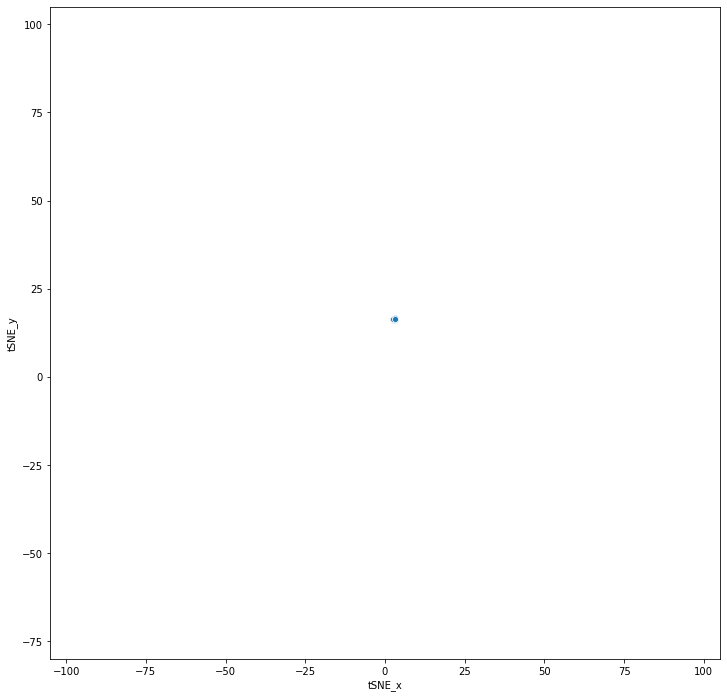

In [58]:
#write a function for visualizing particular clusters steps:
#1) take in the cluster number and a dataframe that has a clustering column, and a vis df with tsne information and whiskey_id

def cluster_vis(cl_number, df, vis_df):
    #2) filter the dataframe for values that match the cluster value given by the user 
    clst = df[df['clustering'] == cl_number]
    #3) merge (inner join) the filtered dataframe into vis_df on whiskey_id 
    mg_df = pd.merge(clst, vis_df, on = 'whiskey_id')
    print(mg_df)
    
    #4) visualize the data using scatterplot
    plt.figure(figsize = (12, 12))
    plt.xlim(-105, 105)
    plt.ylim(-80, 105)
    sns.scatterplot(data = mg_df, x = 'tSNE_x', y = 'tSNE_y')

    plt.show()
    
    
#try for cluster2

cluster_vis(2, ml_df_cl7, vis2)

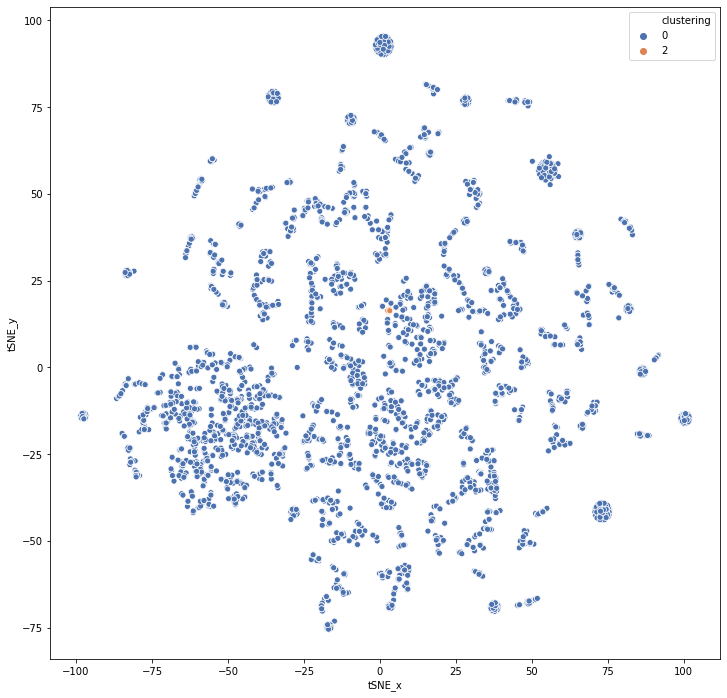

In [65]:
#compare with individual cluster visualizer

vis_ind_clust(cls_7, 2, vis_1)

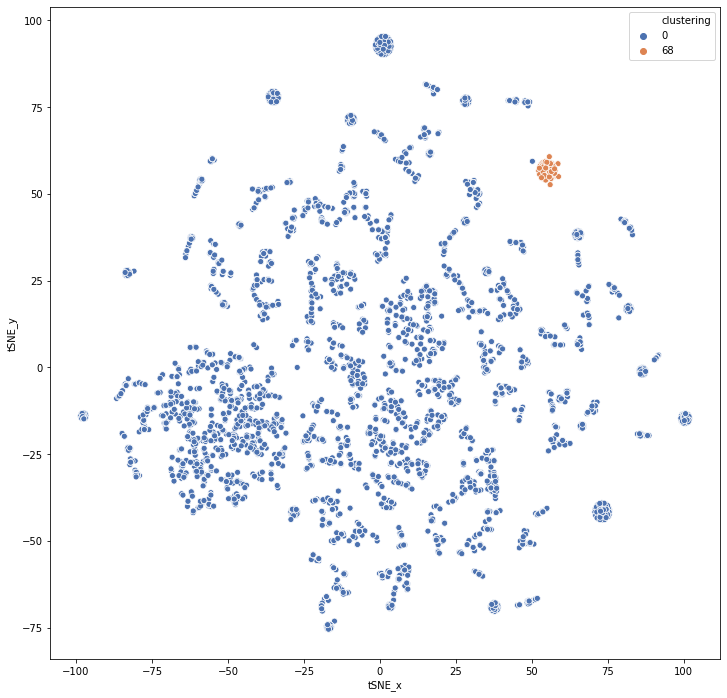

In [68]:
vis_ind_clust(cls_7, 68, vis_1)

In [73]:
cluster68 = ml_df_cl7[ml_df_cl7['clustering'] == 68]

cluster68.head()

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  maillard_prop  \
107         107         1.0        0.0         0.0         0.0            0.0   
110         110         1.0        0.0         0.0         0.0            0.0   
131         131         1.0        0.0         0.0         0.0            0.0   
284         284         1.0        0.0         0.0         0.0            0.0   
289         289         1.0        0.0         0.0         0.0            0.0   

     smoke_prop  clustering  
107         0.0          68  
110         0.0          68  
131         0.0          68  
284         0.0          68  
289         0.0          68

cluster 68 looks like it is 0 values for all but the fruit column, which has a value of 1. These all had only 1 descriptive word which was a fruit word. 

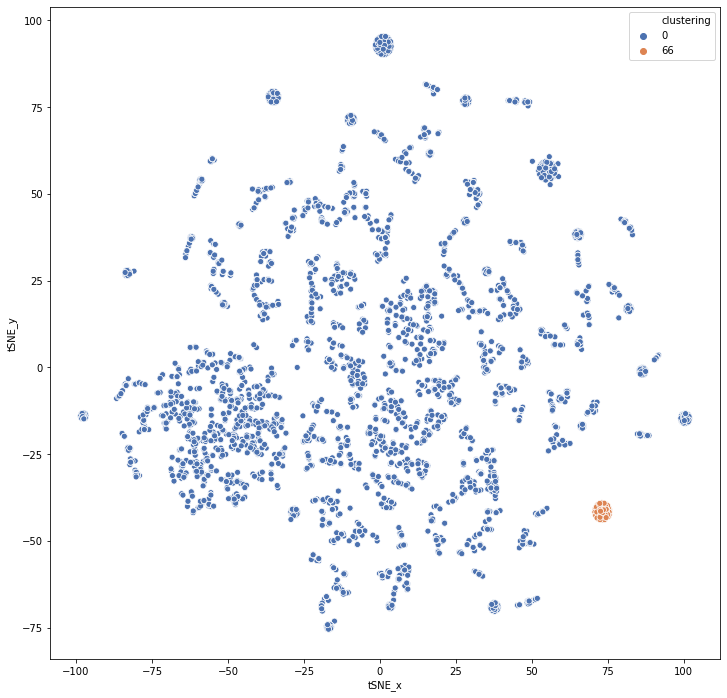

In [74]:
vis_ind_clust(cls_7, 66, vis_1)

In [75]:
cluster66 = ml_df_cl7[ml_df_cl7['clustering'] == 66]

cluster66.head()

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  maillard_prop  \
103         103         0.0        0.0         0.0         0.0            0.0   
105         105         0.0        0.0         0.0         0.0            0.0   
129         129         0.0        0.0         0.0         0.0            0.0   
132         132         0.0        0.0         0.0         0.0            0.0   
285         285         0.0        0.0         0.0         0.0            0.0   

     smoke_prop  clustering  
103         0.0          66  
105         0.0          66  
129         0.0          66  
132         0.0          66  
285         0.0          66

Cluster 66 is not well described by the feature set.

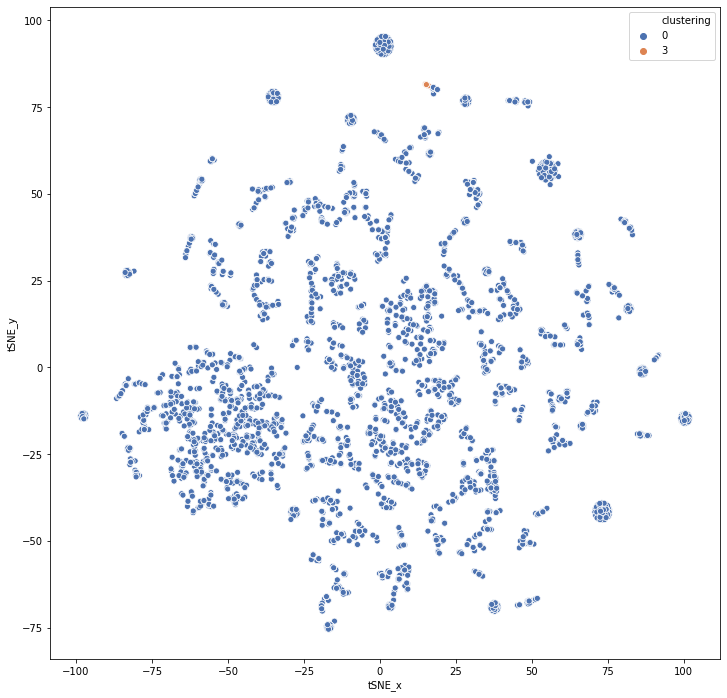

In [76]:
vis_ind_clust(cls_7, 3, vis_1)

In [78]:
cluster3 = ml_df_cl7[ml_df_cl7['clustering'] == 3]

cluster3.head(10)

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  \
3              3    0.250000        0.0         0.0    0.750000   
5              5    0.250000        0.0         0.0    0.750000   
159          159    0.250000        0.0         0.0    0.750000   
1273        1273    0.166667        0.0         0.0    0.833333   
1701        1701    0.166667        0.0         0.0    0.833333   
1753        1753    0.200000        0.0         0.0    0.800000   
2140        2140    0.250000        0.0         0.0    0.750000   
2343        2343    0.250000        0.0         0.0    0.750000   
2580        2580    0.250000        0.0         0.0    0.750000   
3453        3453    0.250000        0.0         0.0    0.750000   

      maillard_prop  smoke_prop  clustering  
3               0.0         0.0           3  
5               0.0         0.0           3  
159             0.0         0.0           3  
1273            0.0         0.0           3  
1701            0.0         0.0           3  
1753            0.0         0.0           3  
2140            0.0         0.0           3  
2343            0.0         0.0           3  
2580            0.0         0.0           3  
3453            0.0         0.0           3

Whiskeys in cluster 3 are not carbon copies, they are just similar. 

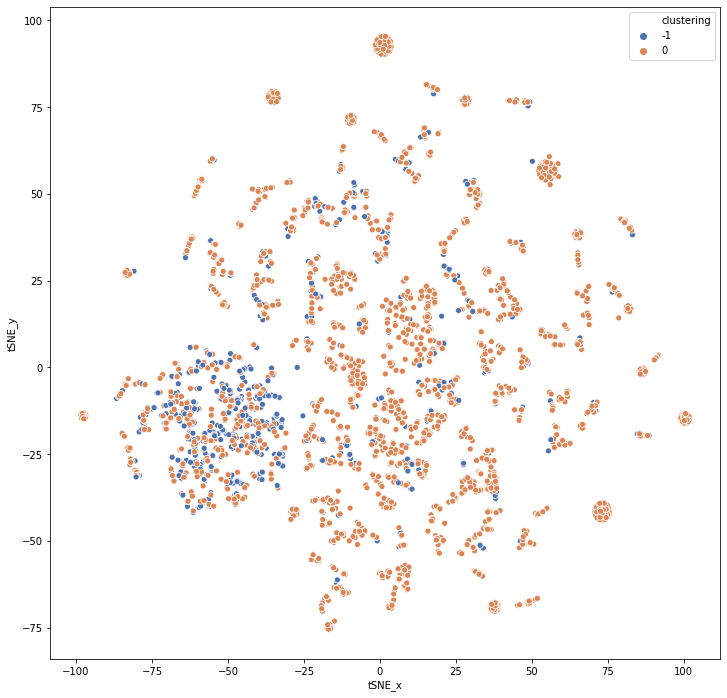

In [79]:
#visualize noise

vis_ind_clust(cls_7, -1, vis_1)

In [80]:
clustern = ml_df_cl7[ml_df_cl7['clustering'] == -1]

clustern.head(10)

whiskey_id  fruit_prop  wood_prop  spicy_prop  sweet_prop  maillard_prop  \
32           32    0.222222   0.222222    0.111111    0.000000       0.444444   
40           40    0.000000   0.250000    0.000000    0.250000       0.125000   
48           48    0.000000   0.125000    0.125000    0.625000       0.125000   
56           56    0.000000   0.625000    0.000000    0.125000       0.250000   
60           60    0.100000   0.200000    0.100000    0.400000       0.200000   
66           66    0.000000   0.166667    0.166667    0.333333       0.166667   
67           67    0.000000   0.200000    0.300000    0.200000       0.100000   
68           68    0.000000   0.222222    0.111111    0.000000       0.222222   
112         112    0.166667   0.000000    0.000000    0.333333       0.166667   
149         149    0.125000   0.250000    0.250000    0.125000       0.125000   

     smoke_prop  clustering  
32     0.000000          -1  
40     0.375000          -1  
48     0.000000          -1  
56     0.000000          -1  
60     0.000000          -1  
66     0.166667          -1  
67     0.200000          -1  
68     0.444444          -1  
112    0.333333          -1  
149    0.125000          -1